In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# EDA

In [239]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

In [240]:
test_pq = pq.read_table('/content/gdrive/MyDrive/tesovye/test.parquet')
train_pq = pq.read_table('/content/gdrive/MyDrive/tesovye/train.parquet')
test_pd = test_pq.to_pandas()
train_pd = train_pq.to_pandas()
train_pd

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
...,...,...,...,...
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0


In [241]:
train_pd.info() #Пустых значений нет, чуть ниже будут обработаны особые случаи

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


среднеяя длина временного ряда: 64.44265


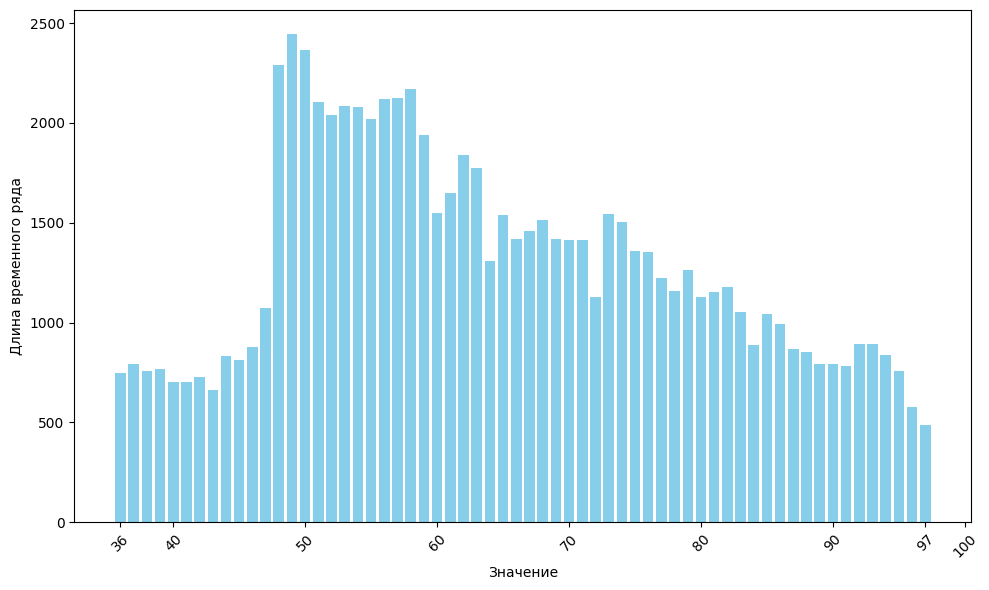

In [243]:
#посмотрим на длины временных рядов (отдельно важно, что нет временных рядов длинной 0, 1 или 2)
lens = [len(s) for s in train_pd['values']]
print('среднеяя длина временного ряда:', np.mean(lens))
value_count_ts = pd.DataFrame(lens).value_counts()

x = list(np.array([x[0] for x in value_count_ts.keys()]))
y = list(value_count_ts.to_numpy())

plt.figure(figsize=(10, 6))
plt.bar(x, y, color='skyblue')

plt.xlabel('Значение')
plt.ylabel('Длина временного ряда')
plt.xticks(rotation=45)
min_value = min(x)  # Минимальное значение
plt.xticks([min(x)] + list(range(40,110,10)) + [max(x)], rotation=45)
plt.tight_layout()
plt.show()

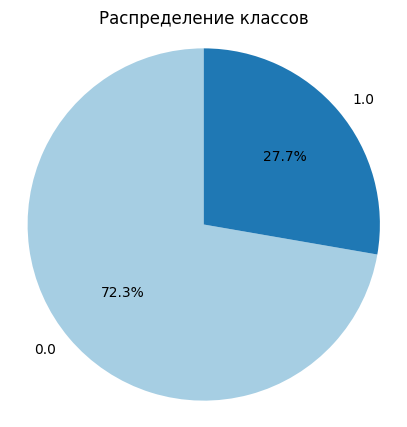

In [244]:
# Посмтри на дисбаланс в классах
# Получаем распределение классов
class_distribution = train_pd['label'].value_counts() / 80000

# Создаем круговую диаграмму
plt.figure(figsize=(5,5))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Распределение классов')
plt.axis('equal')
plt.show()

Сгенерируем признаки из временных рядов

In [245]:
def generate_features(df):
    # Генерация статистических признаков из values
    agg_features = df['values'].apply(lambda x: pd.Series({
        'mean': np.mean(x),
        'median': np.median(x),
        'std': np.std(x),
        'min': np.min(x),
        'max': np.max(x),
        'range': np.max(x) - np.min(x),
        'last_value': x[-1],
        'first_value': x[0],
        'trend': np.polyfit(range(len(x)), x, 1)[0],
        'first_derivative_mean': np.mean(np.gradient(x)),
        'second_derivative_mean': np.mean(np.gradient(np.gradient(x))),
        'autocorr_1': pd.Series(x).autocorr(lag=1),
        'autocorr_2': pd.Series(x).autocorr(lag=2),
        'energy': np.sum(np.power(x, 2)),
        'skewness': pd.Series(x).skew(),
        'kurtosis': pd.Series(x).kurtosis(),
    }))

    # Извлечение временных признаков
    df['dates'] = df['dates'].apply(pd.to_datetime)
    time_features = df['dates'].apply(lambda x: pd.Series({
        'num_years': x.max().year - x.min().year + 1,
        'num_months': len(np.unique(x.month)),
    }))

    # Объединение статистических и временных признаков
    features = pd.concat([agg_features, time_features], axis=1)

    return features

In [ ]:
# Применяем генерацию признаков к тренировочной выборке
train_features = generate_features(train_pd)
train_features['label'] = train_pd['label']

# Применяем генерацию признаков к тестовой выборке
test_features = generate_features(test_pd)

In [247]:
#мы видим, что после преобразований появились nan'ы
#сейчас, когда видны строки, очевидно являющиеся выбросами, мы можем их удалить из трейна
(train_features.isna()).sum()

,0
mean,88
median,88
std,88
min,88
max,88
range,88
last_value,88
first_value,88
trend,88
first_derivative_mean,88


In [248]:
nan_rows = train_pd[train_features.isna().any(axis=1)]
bad_series = []
for s, l in zip(nan_rows['values'], nan_rows['label']):
    bad_series.append((l, s))
print('посмотрим на некоторые временные ряды, являющиеся выбросами:')
print('лейбл = ',bad_series[1][0], 'временной ряд = ',bad_series[1][1])
print('лейбл = ',bad_series[9][0], 'временной ряд = ',bad_series[9][1])

посмотрим на некоторые временные ряды, являющиеся выбросами:
лейбл =  1.0 временной ряд =  [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
лейбл =  1.0 временной ряд =  [-0.17 -0.17 -0.17 -0.17 -0.17 -0.17 -0.17 -0.17 -0.17 -0.17 -0.17 -0.17
 -0.17 -0.17 -0.17 -0.17 -0.17 -0.17 -0.17 -0.17 -0.17 -0.17 -0.17 -0.17
 -0.17 -0.17 -0.17 -0.17 -0.17 -0.17 -0.17 -0.17 -0.17 -0.17 -0.17  5.83]


In [249]:
train_pd = train_pd[~train_features.isna().any(axis=1)]
train_features = train_features[~train_features.isna().any(axis=1)]

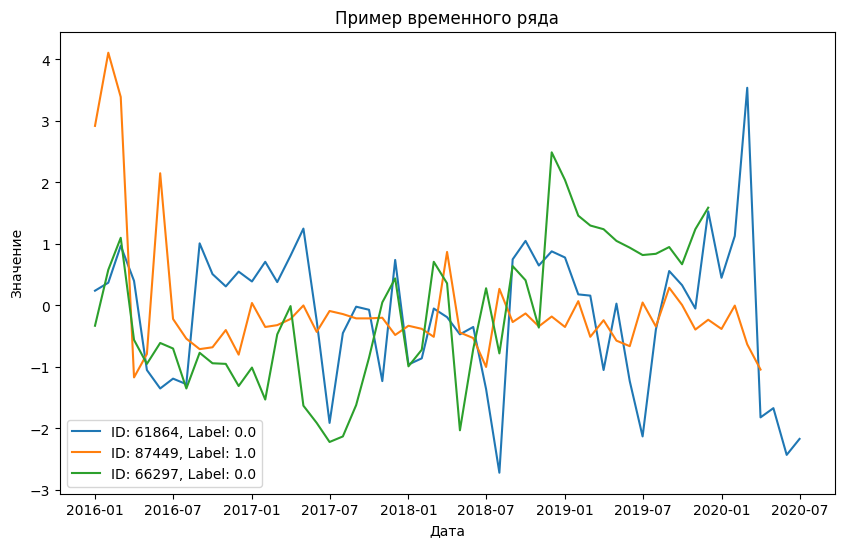

In [250]:
# Визуализация нескольких временных рядов

def plot_time_series(df, idx_list):
    plt.figure(figsize=(10, 6))
    for idx in idx_list:
        row = df.loc[idx]
        dates = pd.to_datetime(row['dates'])
        values = row['values']
        plt.plot(dates, values, label=f"ID: {row['id']}, Label: {row['label']}")
    plt.title('Пример временного ряда')
    plt.xlabel('Дата')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

plot_time_series(train_pd, [14, 8, 3])

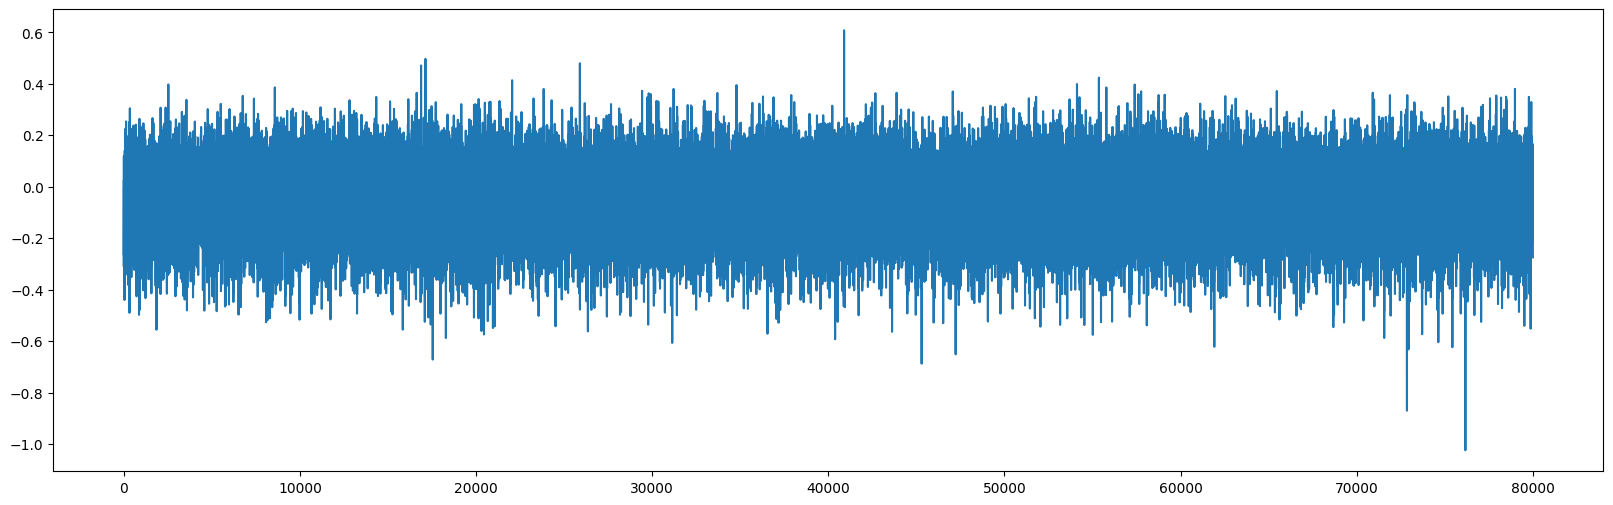

In [251]:
#посмотрим на наличие выброс по сгенерированной фиче среднее временного ряда
plt.figure(figsize=(20, 6))
plt.plot(train_features['mean']);

In [252]:
train_features = train_features[abs(train_features['mean'])<0.52] #Удалим несколько выбросов

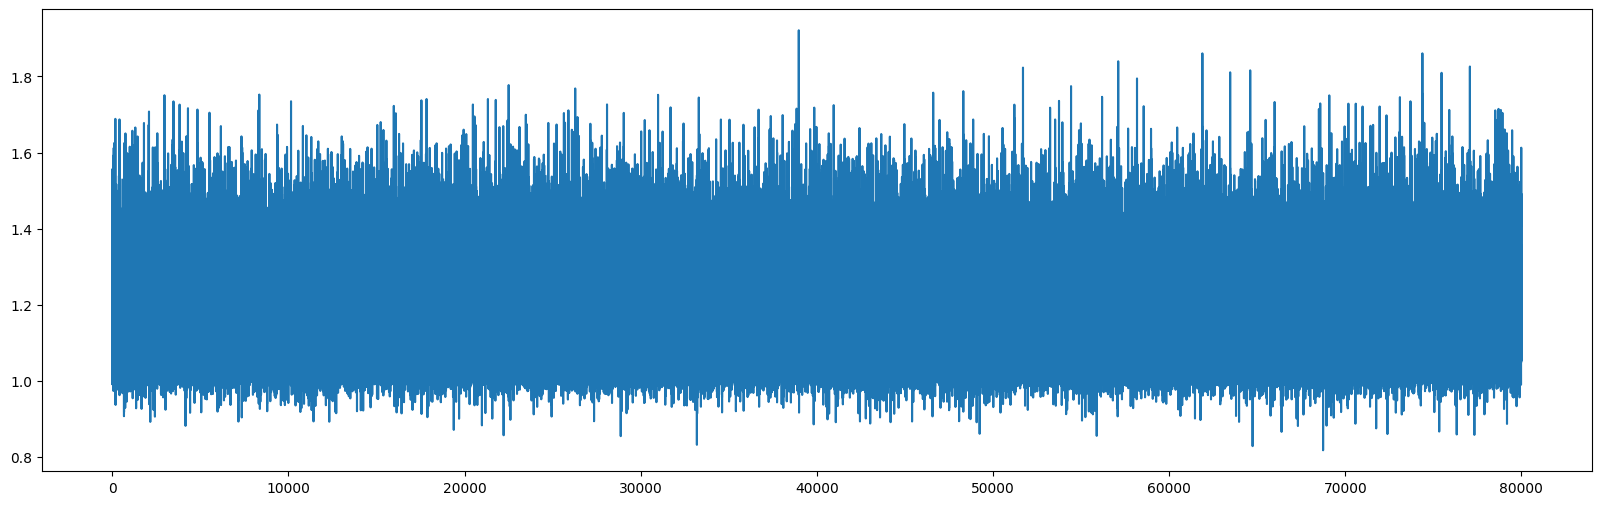

In [253]:
#посмотрим на наличие выброс по сгенерированной фиче стандартное отклонение временного ряда
plt.figure(figsize=(20, 6))
plt.plot(train_features['std']);

In [254]:
train_features = train_features[train_features['std'] < 1.7] #Удалим несколько выбросов

In [256]:
train_features.shape

(79773, 19)

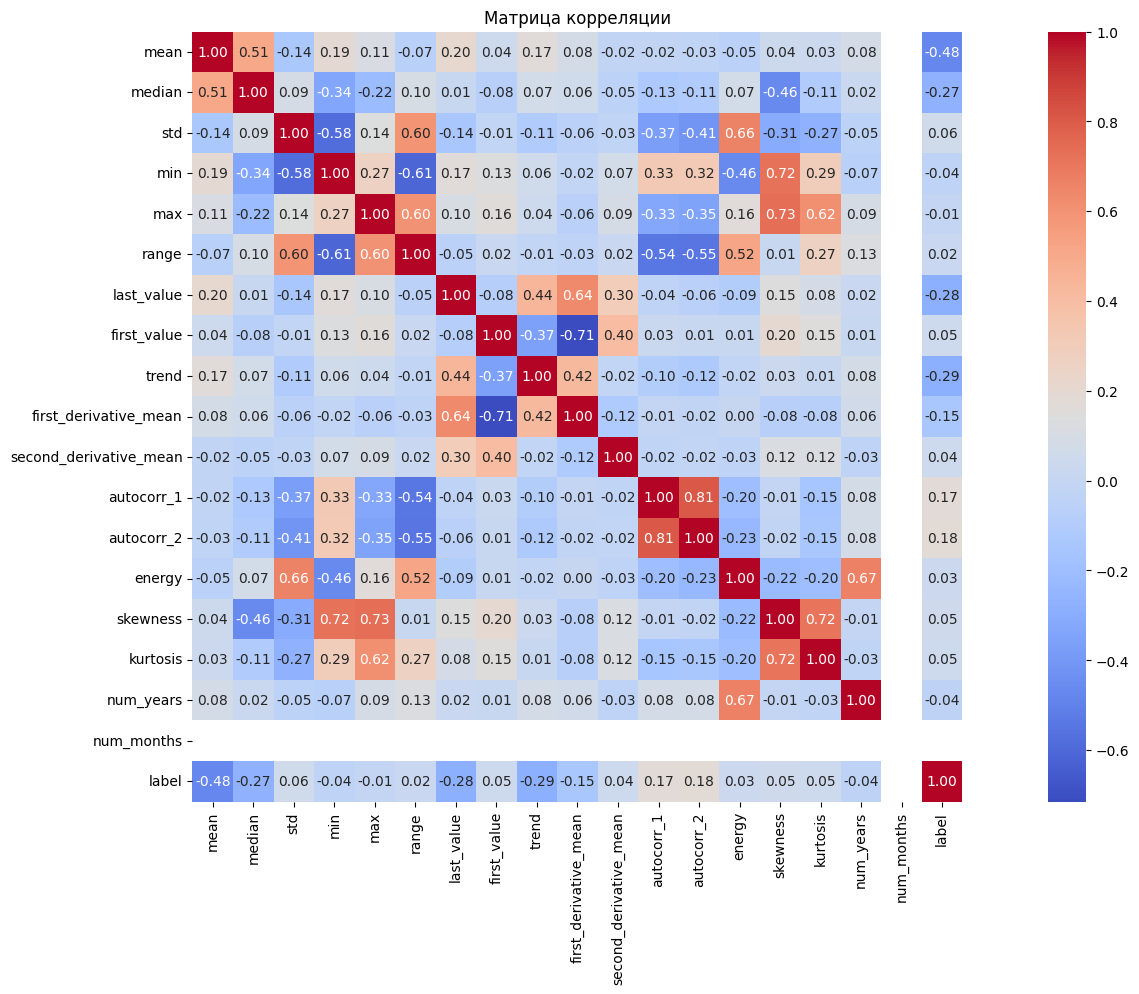

In [257]:
import seaborn as sns

correlation_matrix = train_features.corr()

# Отображение матрицы корреляции
plt.figure(figsize=(22, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Матрица корреляции")
plt.show()
#удалил некоторые фичи, коэф. корелляции которых больше 0.85

# Перейдем к обучению модели

были обучены такие модели как XGBClassifier, BalancedRandomForestClassifier, LogisticRegression, CatBoostClassifier, а так же TimeSeriesForestClassifier из библиотеки sktime. Лучше всех себя проявил CatBoostClassifier

был проведен подбор гиперпараметров с помощью RandomizedSearchCV

In [ ]:
# pip install catboost

In [283]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X = train_features.drop(columns=['label'])
y = train_features['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

catboost_model = CatBoostClassifier(iterations=1000, depth=4, learning_rate=0.1, class_weights=[1, 2.6],  l2_leaf_reg = 10, random_seed=42, verbose=100)

catboost_model.fit(X_train, y_train)

y_val_pred = catboost_model.predict_proba(X_val)[:, 1]

roc_auc = roc_auc_score(y_val, y_val_pred)
print(f"ROC AUC on validation data (CatBoost): {roc_auc:.4f}")

(63818, 18) (15955, 18) (63818,) (15955,)
0:	learn: 0.6582501	total: 16.7ms	remaining: 16.7s
100:	learn: 0.4189788	total: 1.76s	remaining: 15.6s
200:	learn: 0.3997579	total: 3.38s	remaining: 13.4s
300:	learn: 0.3897686	total: 6.67s	remaining: 15.5s
400:	learn: 0.3821505	total: 9.15s	remaining: 13.7s
500:	learn: 0.3758211	total: 10.8s	remaining: 10.7s
600:	learn: 0.3700712	total: 12.4s	remaining: 8.23s
700:	learn: 0.3644644	total: 14.1s	remaining: 6.02s
800:	learn: 0.3594515	total: 15.7s	remaining: 3.9s
900:	learn: 0.3546753	total: 17.4s	remaining: 1.91s
999:	learn: 0.3501169	total: 20.2s	remaining: 0us
ROC AUC on validation data (CatBoost): 0.9034


In [288]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X = train_features.drop(columns=['label'])
y = train_features['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

catboost_model = CatBoostClassifier(iterations=1000, depth=5, learning_rate=0.1, l2_leaf_reg = 10, random_seed=42, verbose=100)

catboost_model.fit(X_train, y_train)

y_val_pred = catboost_model.predict_proba(X_val)[:, 1]

roc_auc = roc_auc_score(y_val, y_val_pred)
print(f"ROC AUC on validation data (CatBoost): {roc_auc:.4f}")

(63818, 18) (15955, 18) (63818,) (15955,)
0:	learn: 0.6316865	total: 16.7ms	remaining: 16.7s
100:	learn: 0.3517646	total: 1.81s	remaining: 16.1s
200:	learn: 0.3365837	total: 4.61s	remaining: 18.3s
300:	learn: 0.3269935	total: 8.28s	remaining: 19.2s
400:	learn: 0.3193284	total: 10s	remaining: 14.9s
500:	learn: 0.3122687	total: 11.7s	remaining: 11.7s
600:	learn: 0.3057457	total: 13.5s	remaining: 8.97s
700:	learn: 0.2996860	total: 15.3s	remaining: 6.51s
800:	learn: 0.2940852	total: 17s	remaining: 4.23s
900:	learn: 0.2887311	total: 21.8s	remaining: 2.39s
999:	learn: 0.2837734	total: 27.2s	remaining: 0us
ROC AUC on validation data (CatBoost): 0.9048


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'iterations': [500, 700б 1000],
    'depth': [10, 12, 16],
    'learning_rate': [0.4, 0.1, 0.06],
    'l2_leaf_reg': [5, 7, 15]
}


random_search = RandomizedSearchCV(estimator=catboost_model, param_distributions=param_grid, n_iter=7, scoring='roc_auc', cv=3)

random_search.fit(X, y)

print("Best parameters found: ", random_search.best_params_)

In [289]:
catboost_model.save_model('catboost_model.cbm')